In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import signal

In [3]:
df = pd.read_csv('Data//cursach//01.txt', sep = ' ', ).rename(columns={"529": 'Data'})
df.head(5)

,Data
0,567
1,747
2,719
3,707
4,728


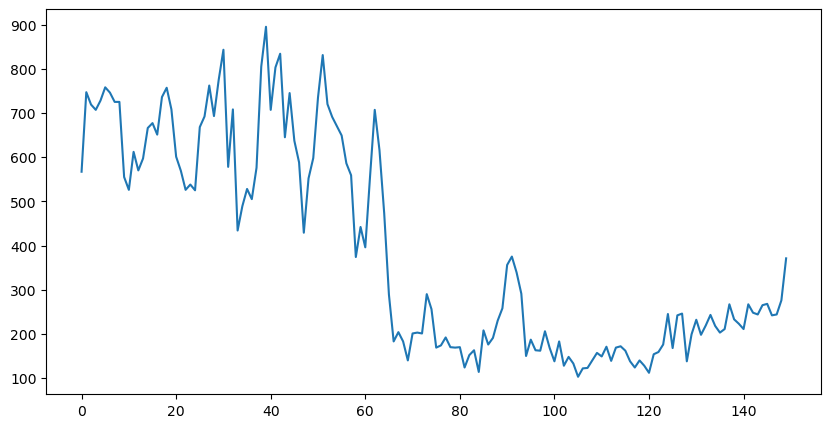

In [4]:
plt.figure(figsize = (10, 5))
plt.plot(df)

In [5]:
X = df['Data']
X

0      567
1      747
2      719
3      707
4      728
      ... 
145    268
146    242
147    244
148    276
149    371
Name: Data, Length: 150, dtype: int64

In [6]:
res = sm.tsa.stattools.kpss(df, nlags = 'auto')
print(f'p-value: {res[1]}')

p-value: 0.01


C:\Users\Shinik\AppData\Local\Temp\ipykernel_10392\683636322.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  res = sm.tsa.stattools.kpss(df, nlags = 'auto')


По тесту KPSS отвергаем гипотезу о стационарности ряда

Посмотрим на периодограммы и спектрограммы исходного ряда

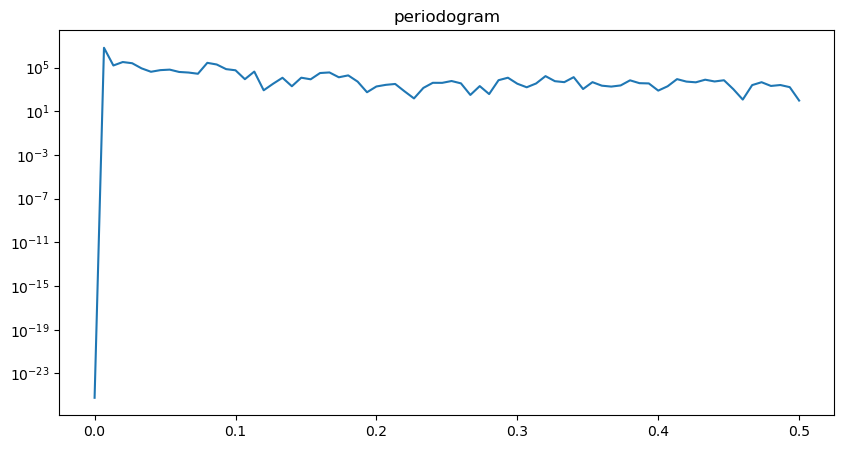

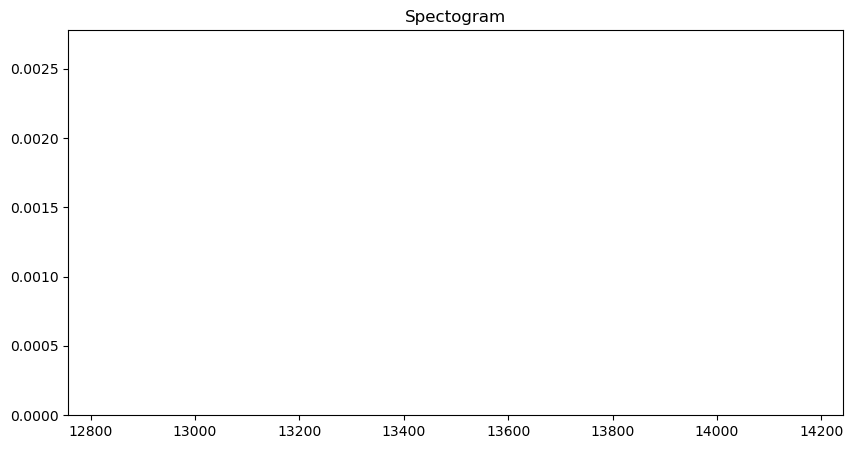

In [7]:
t = np.array(list(range(len(X))))
fs = 1/(X[1] - X[0])
f, tx, Sxx = signal.spectrogram(X, fs, nperseg = 150, noverlap = 80, nfft=4096)
pd, pdden = signal.periodogram(X) # периодограмма

analytic_signal = signal.hilbert(X)
inst_ampl = np.abs(analytic_signal)
instantaneous_phase = np.unwrap(np.angle(analytic_signal))
instantaneous_frequency = (np.diff(instantaneous_phase)/(2.0*np.pi)*fs)
instantaneous_phase = np.unwrap(np.angle(analytic_signal))


plt.figure(figsize = (10, 5))
plt.semilogy(pd, pdden)
plt.title('periodogram')
plt.show()

plt.figure(figsize = (10, 5))
plt.pcolormesh(tx, f, Sxx, shading = 'auto')
plt.title('Spectogram')
plt.show()

Гилберт

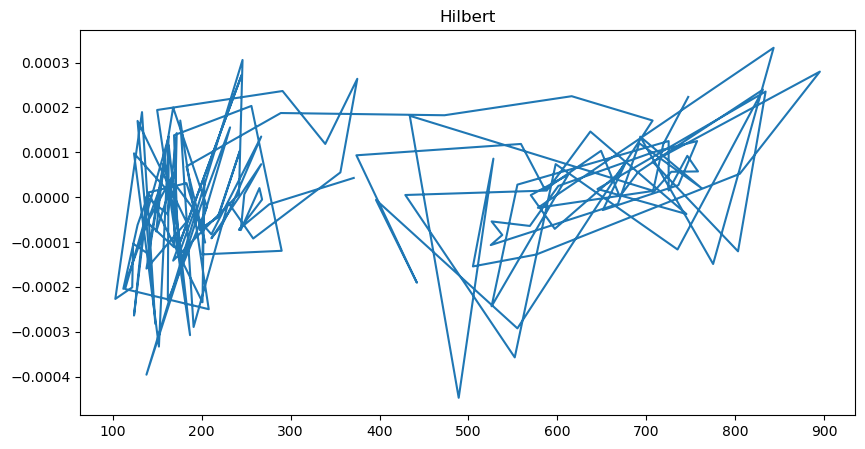

In [8]:
plt.figure(figsize = (10, 5))
plt.plot(X[1:], instantaneous_frequency[0:])
plt.title('Hilbert')
plt.show()

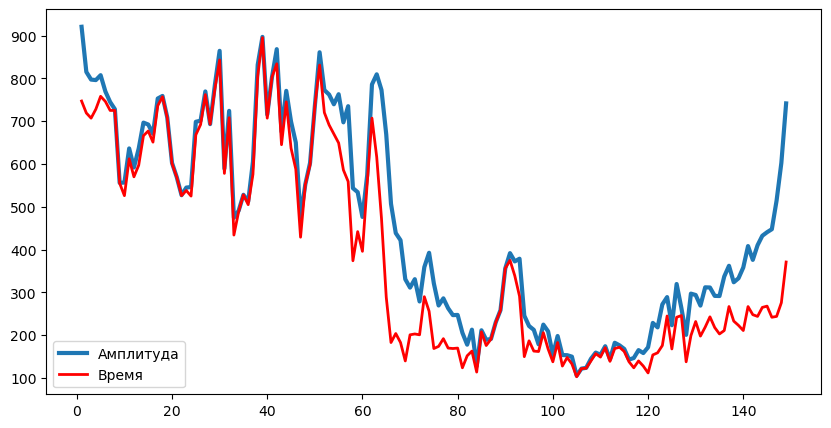

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(t[1:], inst_ampl[1:], label="Амплитуда", linewidth=3)
plt.plot(t[1:], X[1:], label="Время", linewidth=2, c = 'r')
plt.legend(loc="lower left")
plt.show()

Выделим тренд регрессией и сглаживанием

Регрессия

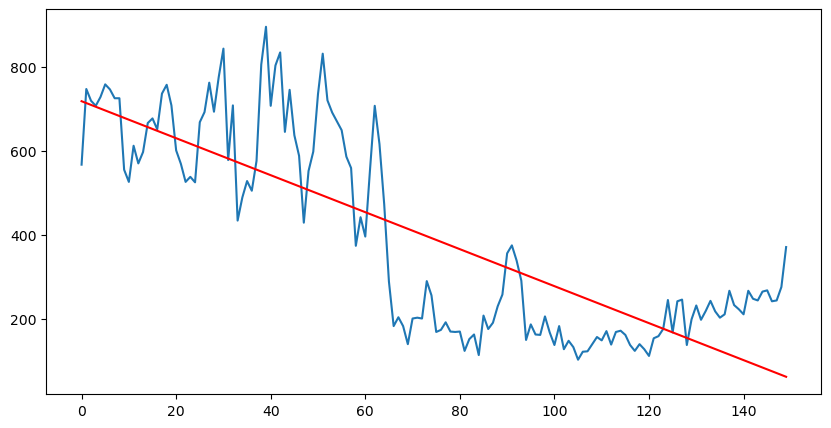

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split


reg = LinearRegression().fit(t.reshape(-1, 1), X)
plt.figure(figsize=(10, 5))
plt.plot(t, X)
plt.plot(t, reg.predict(t.reshape(-1, 1)), c = 'r')

Сглаживание

In [11]:
def exp_smooth(x, a):
    w = [np.mean(x[0:2])]
    for i in range(1, len(x)):
        w.append((1 - a) * w[-1] + a * x[i])
    return w


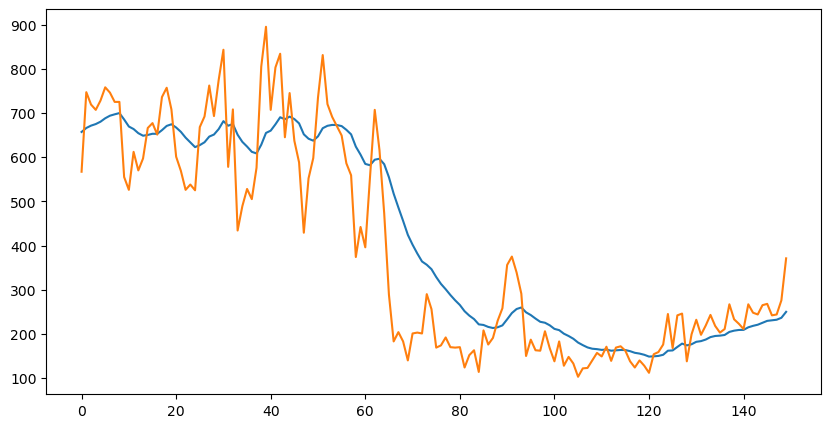

In [12]:
res = exp_smooth(X, 0.1)
plt.figure(figsize=(10, 5))
plt.plot(res)
plt.plot(X)

Взяв 1-й порядок, получим исходный сглаженный ряд, однако если взять порядок 1/10, то получится выделить тренд

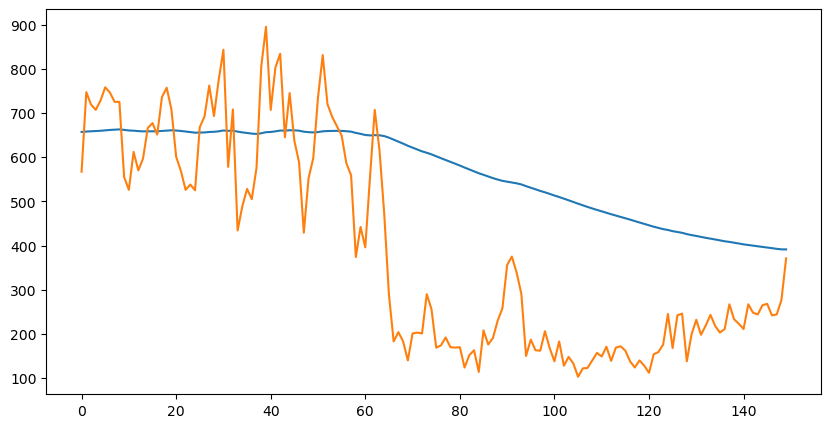

In [13]:
res = exp_smooth(X, 0.01)
plt.figure(figsize=(10, 5))
plt.plot(res)
plt.plot(X)

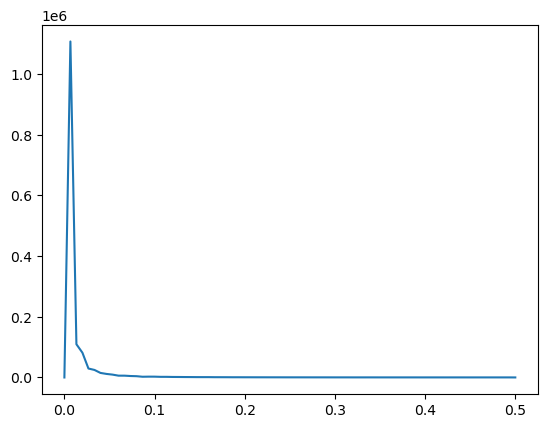

In [16]:
pd, pdden = signal.periodogram(np.array(res))
plt.plot(pd, pdden)

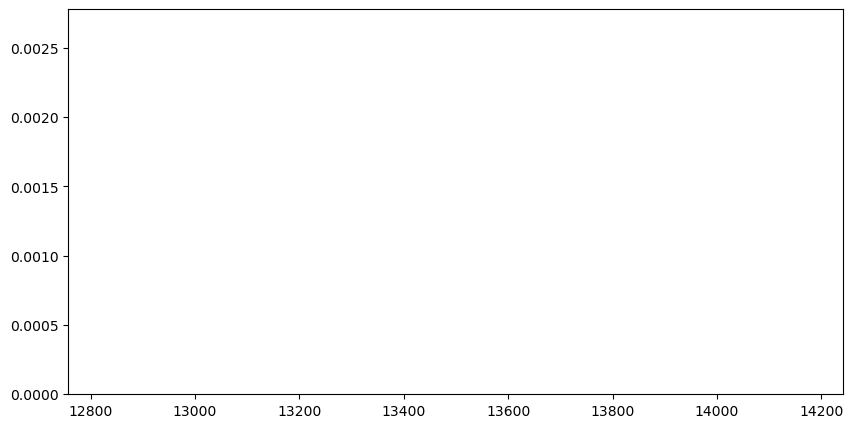

In [22]:
f, tx, Sxx = signal.spectrogram(np.array(res), fs, nperseg = 150, noverlap = 80, nfft=4096)
plt.figure(figsize = (10, 5))
plt.pcolormesh(tx, f, Sxx, shading = 'auto', cmap = 'magma')

Вейвлет-декомпозиция

In [23]:
import pywt

In [39]:
wvlt = 'dmey'
pywt.dwt_max_level(len(X), wvlt)

1

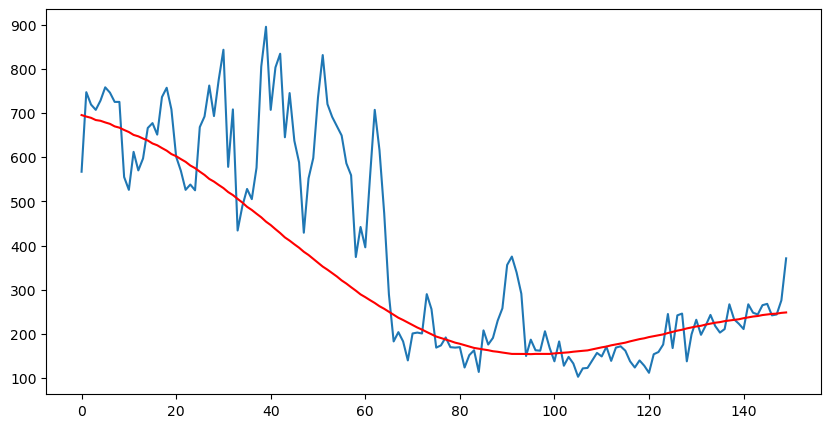

In [211]:
Mode = 'symmetric'
res = pywt.wavedec(X, wvlt, mode=Mode, level=6)
res1 = pywt.waverec((res[0], None, None, None, None, None, None), wvlt, mode = Mode)

plt.figure(figsize = (10, 5))
plt.plot(t, X)
plt.plot(t, res1[19:-19], c = 'r')
plt.show()

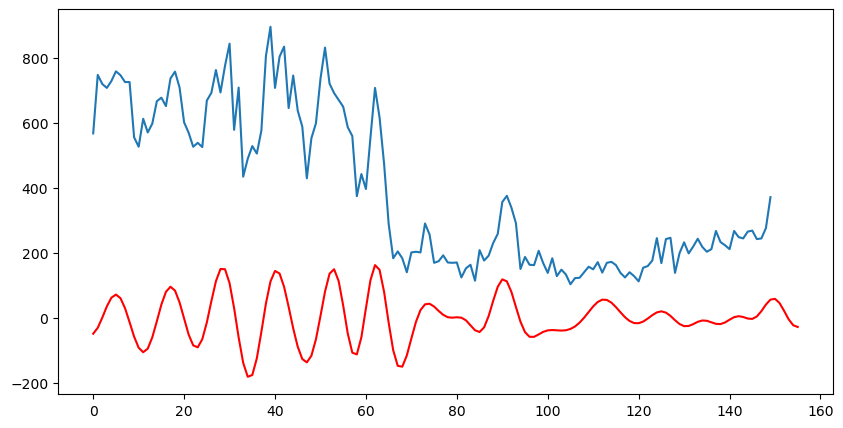

In [220]:
res1 = pywt.waverec((None, res[3], res[4], None, None), wvlt, mode = Mode)

plt.figure(figsize = (10, 5))
plt.plot(X)
plt.plot(res1, c = 'r')
plt.show()

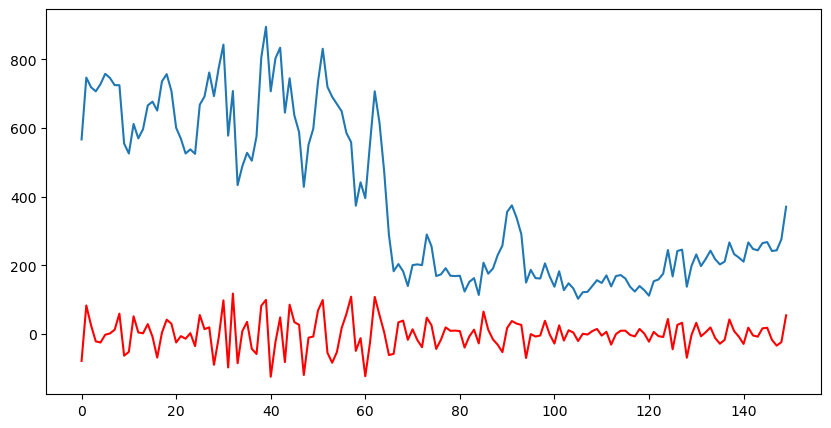

In [188]:
res1 = pywt.waverec((None, res[4], res[5]), wvlt, mode = Mode)

plt.figure(figsize = (10, 5))
plt.plot(X)
plt.plot(res1, c = 'r')
plt.show()

SSA-метод

In [137]:
class SSA_dec:
    def __init__(self, F, L, I):
        self.F = F
        self.L = L
        self.I = I

    def __call__(self):
        A, U, V = self.SSA_modes(self.F, self.L)
        return self.SSA_group(A, U, V, len(self.F), self.I)
    
    def SSA_modes(self, F, L):
        N = len(F)
        K = N - L + 1
        X = np.ones((L, K))
    
        for k in range(L):
            j, m = k, k
            for i in range(j, K+m):
                X[k, i - j] = F[i]

        S = np.dot(X, X.T)
        U, A, _ = np.linalg.svd(S)
        V = np.dot(X.T, U)
    
        return (A, U, V)

    def SSA_group(self, A, U, V, N, I):
        L = len(A)
        V = V.transpose()
        K = N - L + 1
        
        Z = np.dot(U[:, I], V[I, :])
    
        lv = []
        L_min = min(L, K)
        K_max = max(L, K)
    
        for k in range(0, L_min - 1):
            s = 0
            for i in range(k+1):
                s += Z[i, k - i]
            lv.append(round(s/(k+1), 1))

        for k in range(L_min - 1, K_max):
            s = 0
            
            for i in range(L_min):
                s += Z[i, k - i]
            lv.append(round(s/(L_min), 1))
    
        for k in range(K_max, N):
            s = 0
    
            for i in range(k - K_max + 1, N - K_max + 1):
                s += Z[i, k - i]
            lv.append(round(s/(N - k), 1))

        return lv

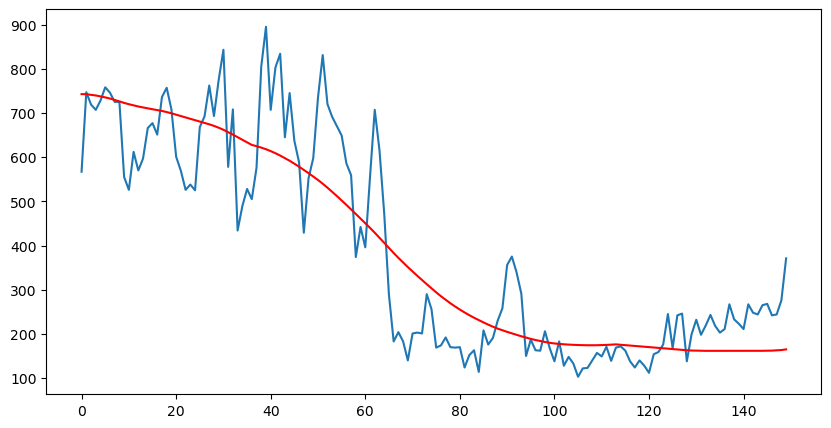

In [245]:
L = len(X)//4
I = [0]
F = X

plt.figure(figsize = (10, 5))
ex = SSA_dec(F, L, I)
plt.plot(F)
plt.plot(ex(), c = 'r')

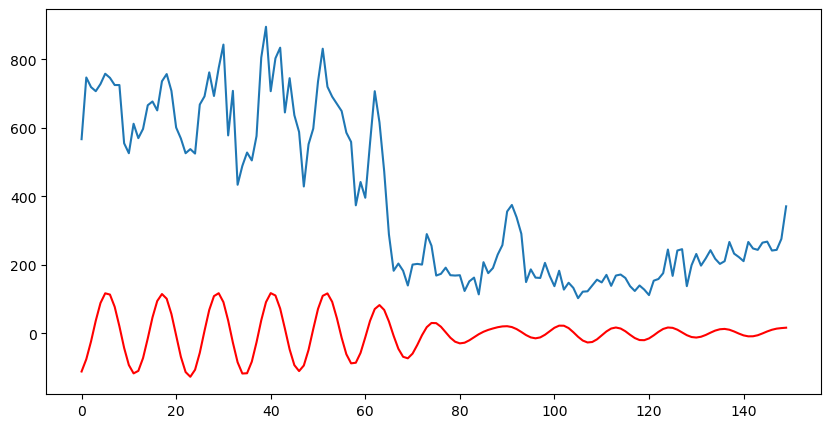

In [246]:
L = len(X)//4
I = [2, 3]
F = X

plt.figure(figsize = (10, 5))
ex = SSA_dec(F, L, I)
plt.plot(F)
plt.plot(ex(), c = 'r')

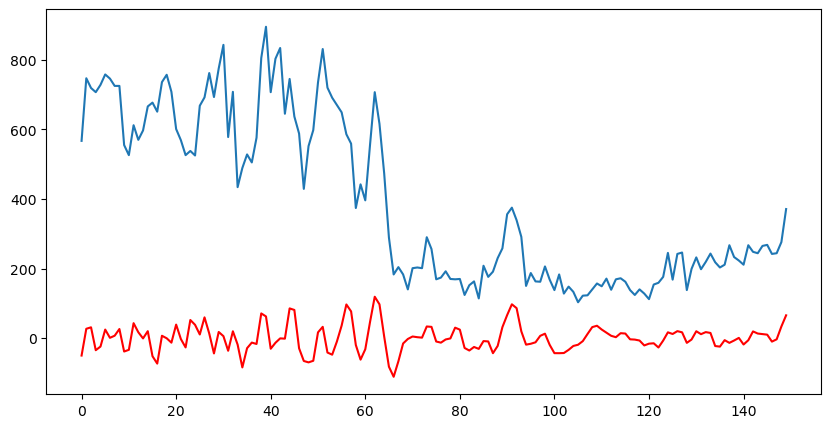

In [248]:
L = len(X)//4
I = [i for i in range(6, 16)]
F = X

plt.figure(figsize = (10, 5))
ex = SSA_dec(F, L, I)
plt.plot(F)
plt.plot(ex(), c = 'r')